# PIP model 🐾 🤖
In this notebook I import and play with my PIP model, designed in blender

In [ ]:
!pip install pybullet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 4.7 MB/s eta 0:00:00


## GPU e CPU setting  🌇 🎥
In Colab u cannot directly connect with `p.connect(GUI)`, that would be necessary for rendering, that's why u gotta adapt thing up a little.

In the cell below we set things up for rendering as explained in this notebook [Here](https://colab.research.google.com/drive/1u6j7JOqM05vUUjpVp5VNk0pd8q-vqGlx#scrollTo=fJXFN4U7NIRC)

In [ ]:
#you can enable the GPU by changing the runtime
import os
os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.3'
os.environ['MESA_GLSL_VERSION_OVERRIDE'] = '330'
import pybullet as p
import pybullet_data as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pylab
from google.colab import widgets
import random
import time

p.connect(p.DIRECT)
#allow to find the assets (URDF, obj, textures etc)
p.setAdditionalSearchPath(pd.getDataPath())

#optionally enable GPU for faster rendering in pybullet.getCameraImage
enableGPU = False
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
import GPUtil as GPU
import sys
# Get all device ids and their processing and memory utiliazion
# (deviceIds, gpuUtil, memUtil) = GPU.getGPUs()

# Print os and python version information
print('OS: ' + sys.platform)
print(sys.version)

# Print package name and version number
print(GPU.__name__ + ' ' + GPU.__version__)

# Show the utilization of all GPUs in a nice table
GPU.showUtilization()

# Show all stats of all GPUs in a nice table
GPU.showUtilization(all=True)

# NOTE: If all your GPUs currently have a memory consumption larger than 1%,
# this step will fail. It's not a bug! It is intended to do so, if it does not
# find an available GPU.
GPUs = GPU.getGPUs()
numGPUs = len(GPU.getGPUs())
print("numGPUs=",numGPUs)
if numGPUs > 0:
  enableGPU = True
eglPluginId = -1
if enableGPU:
  import pkgutil
  egl = pkgutil.get_loader('eglRenderer')
  if (egl):
    eglPluginId = p.loadPlugin(egl.get_filename(), "_eglRendererPlugin")
  else:
    eglPluginId = p.loadPlugin("eglRendererPlugin")

if eglPluginId>=0:
  print("Using GPU hardware (eglRenderer)")
else:
  print("using CPU renderer (TinyRenderer)")

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=c22c723ac4eda0b2d472f14780250b240a1f15451e3904b8949ce9b982c42fcc
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
OS: linux
3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
GPUtil 1.4.0
| ID | GPU | MEM |
------------------
| ID | Name | Serial | UUID || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------------------------------------------------------------------------------------------------------------------------------
numGPUs= 0
using CPU renderer (TinyRenderer)


In [ ]:
!git clone https://github.com/Gaianeve/Real_Mega_Fufi.git

Cloning into 'Real_Mega_Fufi'...
remote: Enumerating objects: 486, done.
remote: Counting objects: 100% (307/307), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 486 (delta 213), reused 183 (delta 115), pack-reused 179 (from 1)
Receiving objects: 100% (486/486), 1.91 MiB | 4.67 MiB/s, done.
Resolving deltas: 100% (298/298), done.


## Loading model 📡 🛰

In [ ]:
%cd Real_Mega_Fufi/Robot/PIPPA

/content/Real_Mega_Fufi/Robot/PIPPA


In [ ]:
p.resetSimulation()
p.configureDebugVisualizer(p.COV_ENABLE_GUI)
#tell him to slide freely on the ground plane
useFixedBase = False
flags = p.URDF_INITIALIZE_SAT_FEATURES

plane_pos = [0,0,-0.1]
plane = p.loadURDF("plane.urdf", plane_pos, flags = flags, useFixedBase=useFixedBase)

# position of the base of the model
PIP_position = [0,0,1.043]
orientation  = [np.pi,0,0]
PIP_orientation = p.getQuaternionFromEuler(orientation)
PIPPA_id = p.loadURDF("PIPPA.urdf",basePosition = PIP_position,baseOrientation = PIP_orientation,\
                      useFixedBase=useFixedBase)


## Useful info and tools 🎮 📚 🏮
Print name and index of the joints and links.

Rembember that in Pybullet the following rule holds:

 🛑 ❗  `linkIndex == jointIndex`




### Link indexes 🔗 🥠


In [ ]:
link_name_to_index = {p.getBodyInfo(PIPPA_id)[0].decode('UTF-8'):-1,}

for id in range(p.getNumJoints(PIPPA_id)):
  name = p.getJointInfo(PIPPA_id, id)[12].decode('UTF-8')
  link_name_to_index[name] = id

print(link_name_to_index)

{'Top_core': -1, 'Top_Link_1': 0, 'Cover_Link1': 1, 'Gamba_Link_1': 2, 'Elastic_Joint_Link_1': 3, 'Colonna_Link_1': 4, 'Bottom_Link_1': 5, 'Top_Link_2': 6, 'Cover_Link_2': 7, 'Gamba_Link_2': 8, 'Elastic_Joint_link_2': 9, 'Colonna_Link_2': 10, 'Bottom_Link_2': 11, 'Top_Link_3': 12, 'Cover_Link_3': 13, 'Gamba_Link_3': 14, 'Elastic_Joint_link_3': 15, 'Colonna_Link_3': 16, 'Bottom_Link_3': 17}


### Joints name and index 🦾 🪴

In [ ]:
joint_name_index = {}

for id in range(p.getNumJoints(PIPPA_id)):
    # Ottieni informazioni sul giunto
    joint_info = p.getJointInfo(PIPPA_id, id)
    name = joint_info[1].decode('UTF-8')  # Utilizza l'indice corretto per il nome del giunto
    joint_name_index[name] = id
    # Stampa il nome e l'indice
    print(f"Giunto: {name}, Indice: {id}")
print(joint_name_index)

Giunto: Cover_to_top_1, Indice: 0
Giunto: Cover_to_leg_1, Indice: 1
Giunto: Leg_to_elastic_1, Indice: 2
Giunto: elastic_to_column_1, Indice: 3
Giunto: Bottom_to_Column_1, Indice: 4
Giunto: Center_to_bottom1, Indice: 5
Giunto: Cover_to_top_2, Indice: 6
Giunto: Cover_to_leg_2, Indice: 7
Giunto: Leg_to_elastic_2, Indice: 8
Giunto: elastic_to_column_2, Indice: 9
Giunto: Bottom_to_column_2, Indice: 10
Giunto: Center_to_bottom2, Indice: 11
Giunto: Cover_to_top_3, Indice: 12
Giunto: Cover_to_leg_3, Indice: 13
Giunto: Leg_to_elastic_3, Indice: 14
Giunto: elastic_to_column_3, Indice: 15
Giunto: Bottom_to_column3, Indice: 16
Giunto: center_to_bottom3, Indice: 17
{'Cover_to_top_1': 0, 'Cover_to_leg_1': 1, 'Leg_to_elastic_1': 2, 'elastic_to_column_1': 3, 'Bottom_to_Column_1': 4, 'Center_to_bottom1': 5, 'Cover_to_top_2': 6, 'Cover_to_leg_2': 7, 'Leg_to_elastic_2': 8, 'elastic_to_column_2': 9, 'Bottom_to_column_2': 10, 'Center_to_bottom2': 11, 'Cover_to_top_3': 12, 'Cover_to_leg_3': 13, 'Leg_to_elas

## TABELLA RIASSUNTIVA DI INDICI DI LINK E GIUNTI

| Tipo    | Nome                     | Indice |
|---------|---------------------------|--------|
| 🔗✨ Link  | Top_core                 | -1     |
| 🔗🌟 Link  | Top_Link_1               | 0      |
| 🔗🎉 Link  | Cover_Link1              | 1      |
| 🔗💫 Link  | Gamba_Link_1             | 2      |
| 🔗🌼 Link  | Elastic_Joint_Link_1     | 3      |
| 🔗🌻 Link  | Colonna_Link_1           | 4      |
| 🔗🍀 Link  | Bottom_Link_1            | 5      |
| 🔗🌺 Link  | Top_Link_2               | 6      |
| 🔗🎈 Link  | Cover_Link_2             | 7      |
| 🔗✨ Link  | Gamba_Link_2             | 8      |
| 🔗🌈 Link  | Elastic_Joint_link_2     | 9      |
| 🔗🌟 Link  | Colonna_Link_2           | 10     |
| 🔗🎉 Link  | Bottom_Link_2            | 11     |
| 🔗💫 Link  | Top_Link_3               | 12     |
| 🔗🌼 Link  | Cover_Link_3             | 13     |
| 🔗🌻 Link  | Gamba_Link_3             | 14     |
| 🔗🍀 Link  | Elastic_Joint_link_3     | 15     |
| 🔗🌺 Link  | Colonna_Link_3           | 16     |
| 🔗🎈 Link  | Bottom_Link_3            | 17     |
|---------|---------------------------|--------|
| ⚙️✨ Giunto| Cover_to_top_1           | 0      |
| ⚙️🌈 Giunto| Cover_to_leg_1           | 1      |
| ⚙️🌟 Giunto| Leg_to_elastic_1         | 2      |
| ⚙️🎉 Giunto| elastic_to_column_1      | 3      |
| ⚙️💫 Giunto| Bottom_to_Column_1       | 4      |
| ⚙️🌼 Giunto| Center_to_bottom1        | 5      |
| ⚙️🌻 Giunto| Cover_to_top_2           | 6      |
| ⚙️🍀 Giunto| Cover_to_leg_2           | 7      |
| ⚙️🌺 Giunto| Leg_to_elastic_2         | 8      |
| ⚙️🎈 Giunto| elastic_to_column_2      | 9      |
| ⚙️✨ Giunto| Bottom_to_column_2       | 10     |
| ⚙️🌈 Giunto| Center_to_bottom2        | 11     |
| ⚙️🌟 Giunto| Cover_to_top_3           | 12     |
| ⚙️🎉 Giunto| Cover_to_leg_3           | 13     |
| ⚙️💫 Giunto| Leg_to_elastic_3         | 14     |
| ⚙️🌼 Giunto| elastic_to_column_3      | 15     |
| ⚙️🌻 Giunto| Bottom_to_column3        | 16     |
| ⚙️🍀 Giunto| center_to_bottom3        | 17     |


## Changing material of the links ⛵ 🦚
Assign material trough the properties by changing dinamics. Everything about elastic joint Young modulus is being dealt with in the urdf file.

Basically, the joint is modelized as a *neo hookean* soft body  ♨ 🗻. Again, see the guide or my notes for the details.

In [ ]:
# AL 6082 (Alluminio)
lateralFriction_Al = 0.3
restitution_Al = 0.2
rollingFriction_Al = 0.001
spinningFriction_Al = 0.01
linearDamping_Al = 0.04
angularDamping_Al = 0.1
contactStiffness_Al = 3e6
contactDamping_Al = 800

# AISI 304 (Acciaio Inox)
lateralFriction_AISI = 0.4
restitution_AISI = 0.1
rollingFriction_AISI = 0.001
spinningFriction_AISI= 0.05
linearDamping_AISI = 0.03
angularDamping_AISI = 0.1
contactStiffness_AISI = 8e6
contactDamping_AISI = 1500

# Acciaio Maraging (Maragià per gli amici)
lateralFriction_Mar = 0.3
restitution_Mar = 0.2
rollingFriction_Mar = 0.001
spinningFriction_Mar = 0.02
linearDamping_Mar = 0.04
angularDamping_Mar = 0.15
contactStiffness_Mar = 3e6
contactDamping_Mar = 800

### Physics parameters explanation 🎈 🔮

1.  `lateralFriction=0.9` 🐑

  *   **Descrizione**: Rappresenta il coefficiente di attrito laterale tra il link e la superficie su cui entra in contatto.
  *   **Effetto:**  Più alto è il valore, maggiore sarà l'attrito tra il link e la superficie, il che significa che il link resisterà di più allo scivolamento lungo la superficie. Un valore di 1.0 o vicino a esso significa un attrito alto, mentre un valore basso (come 0.1) indica poco attrito, e il link scivolerà più facilmente.

  *   **Esempio:** Materiali ruvidi o che non scivolano facilmente, come gomma o superfici ruvide, hanno un coefficiente di attrito più alto. Materiali come ghiaccio o superfici lisce e scivolose avranno un coefficiente basso.

*Caso Acciaio*: Il valore 0.9 è abbastanza alto, riflettendo l'alto attrito dell'acciaio maraging a contatto con superfici ruvide o altri metalli.


2.  `restitution=0.1` 🐬

  *   **Descrizione**: Rappresenta il coefficiente di restituzione, che determina quanto "rimbalza" un oggetto dopo un impatto.

  *   **Effetto:**  Un valore di 1.0 significa che l'oggetto rimbalza completamente (energia conservata), mentre un valore di 0.0 significa che non c'è rimbalzo (l'energia viene completamente assorbita).

  *   **Esempio:** Materiali elastici come la gomma hanno un alto coefficiente di restituzione (vicino a 1.0), mentre materiali rigidi e non elastici come il piombo o l'acciaio hanno un coefficiente basso.

*Caso Acciaio*: L'acciaio ha un basso coefficiente di restituzione (intorno a 0.1), il che significa che non rimbalza molto dopo un impatto, riflettendo la sua natura rigida e non elastica.


3.  `contactStiffness=1e6` 🐨

  *   **Descrizione**: Rappresenta la rigidità del contatto, o quanto è resistente il materiale alla compressione quando viene a contatto con un'altra superficie.

  *   **Effetto:**  Un valore più alto significa che il materiale è molto rigido e si deformerà pochissimo durante un contatto (simulando l'effetto di un modulo di Young alto), mentre un valore basso rappresenta materiali più morbidi che si deformano più facilmente.

  *   **Esempio:** Materiali come il gommapiuma hanno una bassa rigidità del contatto, mentre materiali molto rigidi come acciaio o ceramica hanno un'alta rigidità.

*Caso Acciaio*: Un valore come 1e6 simula una rigidezza molto alta, tipica dell'acciaio maraging, che si deforma molto poco sotto pressione.


4.  `contactDamping=1e3` 🦘
  
  *   **Descrizione**: Rappresenta lo smorzamento del contatto, che controlla quanto velocemente l'energia del contatto viene dissipata nel tempo.

  *   **Effetto:** Un valore più alto significa che il contatto perde energia rapidamente, smorzando le vibrazioni o il rimbalzo. Un valore basso implica che il sistema è più elastico e manterrà energia più a lungo.

  *   **Esempio:** Un materiale molto elastico, come una molla ben tesa, ha uno smorzamento basso, il che significa che rimbalza e vibra a lungo. Un materiale con alto smorzamento, come l'acciaio, disperde rapidamente energia durante un impatto, quindi non rimbalza molto e smorza le vibrazioni.

*Caso Acciaio*: Il valore 1e3 rappresenta uno smorzamento moderato, coerente con il comportamento dell'acciaio maraging, che dissipa energia abbastanza rapidamente senza rimbalzi significativi.


❕📔🖊 *Note* : *For more detailon the parameters see the parameters see my notes or pybullet Quickstart guide, everything's in there*.

❗ Not all parameters are important when simulating, so caution with that choise. **To be decided with max.**

In [ ]:
link_indices_Al = [link_name_to_index['Bottom_Link_1'],link_name_to_index['Bottom_Link_2'],\
                   link_name_to_index['Bottom_Link_3'], link_name_to_index['Gamba_Link_1'],\
                   link_name_to_index['Gamba_Link_2'], link_name_to_index['Gamba_Link_3'],\
                   link_name_to_index['Top_core'], link_name_to_index['Cover_Link1'], \
                   link_name_to_index['Cover_Link_2'], link_name_to_index['Cover_Link_3']]

link_indices_AISI = [link_name_to_index['Top_Link_2'], link_name_to_index['Top_Link_3'],\
                     link_name_to_index['Top_Link_1'], link_name_to_index['Colonna_Link_1'],\
                     link_name_to_index['Colonna_Link_2'],link_name_to_index['Colonna_Link_3']]

link_indices_Mar = [link_name_to_index['Elastic_Joint_Link_1'], link_name_to_index['Elastic_Joint_link_2'],\
                    link_name_to_index['Elastic_Joint_link_3']]

# Al 6082
for link in link_indices_Al:
  p.changeDynamics(PIPPA_id, link, lateralFriction=lateralFriction_Al,\
                   restitution=restitution_Al, \
                   spinningFriction= spinningFriction_Al, rollingFriction= rollingFriction_Al,\
                   linearDamping=linearDamping_Al, angularDamping=angularDamping_Al,\
                   contactStiffness = contactStiffness_Al,contactDamping = contactDamping_Al)
# AISI 304
for link in link_indices_AISI:
  p.changeDynamics(PIPPA_id, link, lateralFriction=lateralFriction_AISI,\
                   restitution=restitution_AISI, \
                   spinningFriction= spinningFriction_AISI, rollingFriction= rollingFriction_AISI,\
                   linearDamping=linearDamping_AISI, angularDamping=angularDamping_AISI,\
                   contactStiffness = contactStiffness_AISI, contactDamping = contactDamping_AISI)
# Maragià
for link in link_indices_AISI:
  p.changeDynamics(PIPPA_id, link, lateralFriction=lateralFriction_Mar,\
                   restitution=restitution_Mar, \
                   spinningFriction= spinningFriction_Mar, rollingFriction= rollingFriction_Mar,\
                   linearDamping=linearDamping_Mar, angularDamping=angularDamping_Mar,\
                   contactStiffness = contactStiffness_Mar, contactDamping = contactDamping_Mar)

## Start simulation 🚀 🪖
Adding gravity 🍎 ⬇ to the system and starting the physics simulation 🏃 🔥 🛕 ⛩ ⛪ .


In [ ]:
%%time
camTargetPos = [0, 0, 0]
cameraUp = [0, 0, 1]
cameraPos = [1, 1, 1]
p.setGravity(0, 0, -10)


CPU times: user 71 µs, sys: 12 µs, total: 83 µs
Wall time: 88.9 µs


## Animated images to see PIPPA 🎥 💥
The axiz you see going from left to right is the x axis.

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

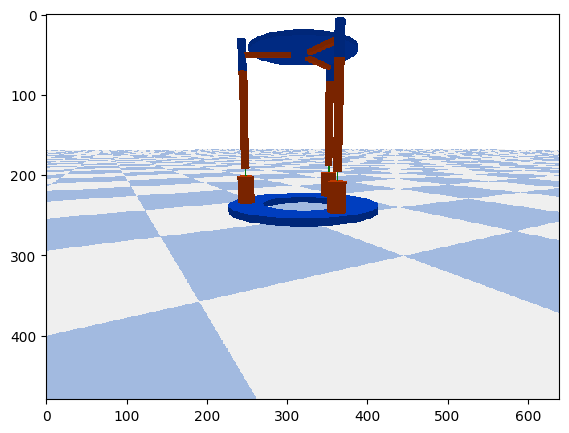

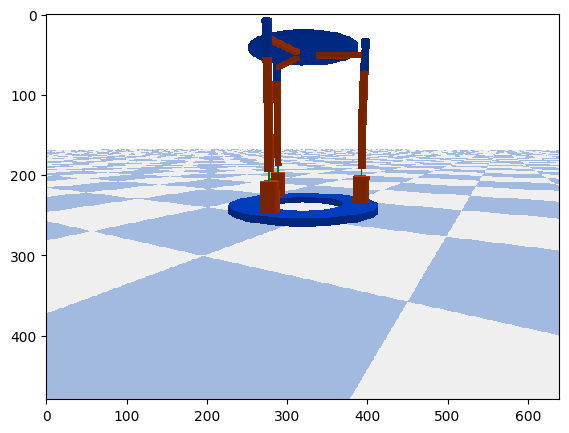

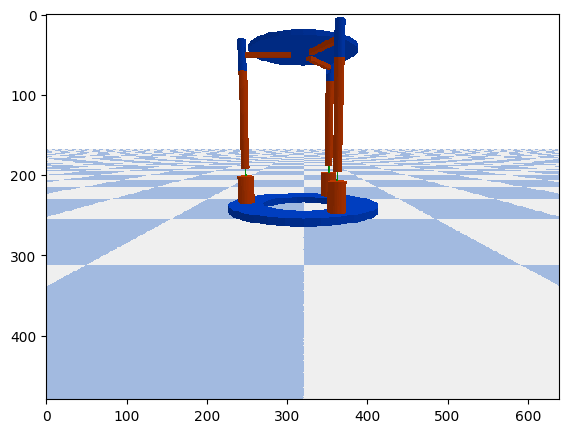

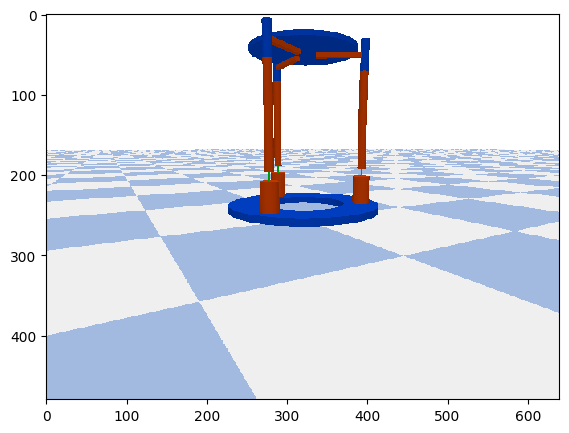

In [ ]:
from google.colab import widgets
import numpy as np
import random
import time
from matplotlib import pylab
grid = widgets.Grid(2, 2)
yaw = 0
for r in range(2):
  for c in range(2):
    yaw += 60
    with grid.output_to(r, c):
      grid.clear_cell()
      pylab.figure(figsize=(10, 5))
      pitch = -10.0
      roll = 0
      upAxisIndex = 2
      camDistance = 2.5
      pixelWidth = 640
      pixelHeight = 480
      nearPlane = 0.01
      farPlane = 100
      fov = 60
      viewMatrix = p.computeViewMatrixFromYawPitchRoll(camTargetPos, camDistance, yaw, pitch,
                                                                  roll, upAxisIndex)
      aspect = pixelWidth / pixelHeight
      projectionMatrix = p.computeProjectionMatrixFOV(fov, aspect, nearPlane, farPlane)

      img_arr = p.getCameraImage(pixelWidth,pixelHeight,viewMatrix,projectionMatrix)
      w = img_arr[0]  #width of the image, in pixels
      h = img_arr[1]  #height of the image, in pixels
      rgb = img_arr[2]  #color data RGB
      dep = img_arr[3]  #depth data
      print("w=",w,"h=",h)
      np_img_arr = np.reshape(rgb, (h, w, 4))
      np_img_arr = np_img_arr * (1. / 255.)
      pylab.imshow(np_img_arr, interpolation='none', animated=True, label="pybullet")


### Let's try  png image
code for creating ong is commented below

In [ ]:
'''
!pip install numpngw
from numpngw import write_apng
from IPython.display import Image

frames=[] #frames to create animated png
for r in range(60):
    yaw += 6
    pitch = -10.0
    roll = 0
    upAxisIndex = 2
    camDistance = 2.5
    pixelWidth = 320
    pixelHeight = 200
    nearPlane = 0.01
    farPlane = 100
    fov = 60
    viewMatrix = p.computeViewMatrixFromYawPitchRoll(camTargetPos, camDistance, yaw, pitch,
                                                                roll, upAxisIndex)
    aspect = pixelWidth / pixelHeight
    projectionMatrix = p.computeProjectionMatrixFOV(fov, aspect, nearPlane, farPlane)

    img_arr = p.getCameraImage(pixelWidth,pixelHeight,viewMatrix,projectionMatrix)
    w = img_arr[0]  #width of the image, in pixels
    h = img_arr[1]  #height of the image, in pixels
    rgb = img_arr[2]  #color data RGB
    dep = img_arr[3]  #depth data
    #print("w=",w,"h=",h)
    np_img_arr = np.reshape(rgb, (h, w, 4))
    frame = np_img_arr[:, :, :3]
    frames.append(frame)
print("creating animated png, please about 5 seconds")
%time write_apng("example6.png", frames, delay=100)
%time Image(filename="example6.png")
'''

'\n!pip install numpngw\nfrom numpngw import write_apng\nfrom IPython.display import Image\n\nframes=[] #frames to create animated png\nfor r in range(60):\n    yaw += 6\n    pitch = -10.0\n    roll = 0\n    upAxisIndex = 2\n    camDistance = 2.5\n    pixelWidth = 320\n    pixelHeight = 200\n    nearPlane = 0.01\n    farPlane = 100\n    fov = 60\n    viewMatrix = p.computeViewMatrixFromYawPitchRoll(camTargetPos, camDistance, yaw, pitch,\n                                                                roll, upAxisIndex)\n    aspect = pixelWidth / pixelHeight\n    projectionMatrix = p.computeProjectionMatrixFOV(fov, aspect, nearPlane, farPlane)\n\n    img_arr = p.getCameraImage(pixelWidth,pixelHeight,viewMatrix,projectionMatrix)\n    w = img_arr[0]  #width of the image, in pixels\n    h = img_arr[1]  #height of the image, in pixels\n    rgb = img_arr[2]  #color data RGB\n    dep = img_arr[3]  #depth data\n    #print("w=",w,"h=",h)\n    np_img_arr = np.reshape(rgb, (h, w, 4))\n    frame =

## Try moving PIPPA 🎮 🐧

In [ ]:
## 1,2,3 numeration for bottom bars, force positions and lvdts are consistent

#bottom disk bars index
bottom_link_1_index = link_name_to_index['Bottom_Link_1']
bottom_link_2_index = link_name_to_index['Bottom_Link_2']
bottom_link_3_index = link_name_to_index['Bottom_Link_3']

#get bottom bar position to apply forces there
initial_position_bottom_1, initial_orientation_bottom_1 = p.getLinkState(PIPPA_id, bottom_link_1_index)[0:2]
initial_position_bottom_2, initial_orientation_bottom_2 = p.getLinkState(PIPPA_id, bottom_link_2_index)[0:2]
initial_position_bottom_3, initial_orientation_bottom_3 = p.getLinkState(PIPPA_id, bottom_link_3_index)[0:2]

initial_angles_bottom_1 = p.getEulerFromQuaternion(initial_orientation_bottom_1)
initial_angles_bottom_2 = p.getEulerFromQuaternion(initial_orientation_bottom_2)
initial_angles_bottom_3 = p.getEulerFromQuaternion(initial_orientation_bottom_3)

print("Initial bottom bars position:")
print('Bar 1', initial_position_bottom_1)
print('Bar 2', initial_position_bottom_2)
print('Bar 3', initial_position_bottom_3)

print("Initial bottom bars angles:")
print('Angles 1',initial_angles_bottom_1)
print('Angles 1',initial_angles_bottom_2)
print('Angles 1',initial_angles_bottom_3)

#lvdt index
lvdt_1_index = joint_name_index['Cover_to_leg_1']
lvdt_2_index = joint_name_index['Cover_to_leg_2']
lvdt_3_index = joint_name_index['Cover_to_leg_3']

#3 lvdt info (joint cover-leg)
lvdt_1_initial_position, lvdt_1_initial_velocity  = p.getJointState(PIPPA_id, lvdt_1_index)[0:2]
lvdt_2_initial_position, lvdt_2_initial_velocity  = p.getJointState(PIPPA_id, lvdt_2_index)[0:2]
lvdt_3_initial_position, lvdt_3_initial_velocity  = p.getJointState(PIPPA_id, lvdt_3_index)[0:2]

print("LVDT 1 initial position and velocity:", lvdt_1_initial_position, lvdt_1_initial_velocity)
print("LVDT 2 initial position and velocity:", lvdt_2_initial_position, lvdt_2_initial_velocity)
print("LVDT 3 initial position and velocity:", lvdt_3_initial_position, lvdt_3_initial_velocity)

#get leg initial position
leg_1_index = link_name_to_index['Gamba_Link_1']
leg_2_index = link_name_to_index['Gamba_Link_2']
leg_3_index = link_name_to_index['Gamba_Link_3']

initial_position_leg_1, initial_orientation_leg_1 = p.getLinkState(PIPPA_id, leg_1_index)[0:2]
initial_position_leg_2, initial_orientation_leg_2 = p.getLinkState(PIPPA_id, leg_2_index)[0:2]
initial_position_leg_3, initial_orientation_leg_3 = p.getLinkState(PIPPA_id, leg_3_index)[0:2]

print("Initial legs position:")
print('Bar 1', initial_position_bottom_1)
print('Bar 2', initial_position_bottom_2)
print('Bar 3', initial_position_bottom_3)

Initial bottom bars position:
Bar 1 (-2.098717095483371e-05, 7.799120402320341e-08, -8.655897520438993e-05)
Bar 2 (-0.0005183540855795976, 0.0004721485807539505, -7.491869042701611e-05)
Bar 3 (-0.0006942729551661919, -0.0002628659481606621, -7.489016984651986e-05)
Initial bottom bars angles:
Angles 1 (1.5709999999662045, -8.296554071529636e-08, 1.5714073464017577)
Angles 1 (1.5706322465976998, 0.0003754611753255829, -2.6182037473324207)
Angles 1 (1.5707217832567955, -0.00012921451886279832, -0.5237962956628525)
LVDT 1 initial position and velocity: 0.0 0.0
LVDT 2 initial position and velocity: 0.0 0.0
LVDT 3 initial position and velocity: 0.0 0.0
Initial legs position:
Bar 1 (-2.098717095483371e-05, 7.799120402320341e-08, -8.655897520438993e-05)
Bar 2 (-0.0005183540855795976, 0.0004721485807539505, -7.491869042701611e-05)
Bar 3 (-0.0006942729551661919, -0.0002628659481606621, -7.489016984651986e-05)


In [ ]:
%%time
force_module = np.array([0,0,0])
#apply equal force to the border of our bottom disk
force_position_1 = initial_position_bottom_1
force_position_2 = initial_position_bottom_2
force_position_3 = initial_position_bottom_3

#apply external forces to the bottom edges of the disk
p.applyExternalForce(
    objectUniqueId=PIPPA_id,linkIndex= leg_1_index,forceObj=force_module, posObj=force_position_1,flags=p.WORLD_FRAME)
p.applyExternalForce(
    objectUniqueId=PIPPA_id,linkIndex= leg_2_index,forceObj=force_module, posObj=force_position_2,flags=p.WORLD_FRAME)
p.applyExternalForce(
    objectUniqueId=PIPPA_id,linkIndex= leg_3_index,forceObj=force_module, posObj=force_position_2,flags=p.WORLD_FRAME)
for _ in range(1000):
    p.stepSimulation()  # Aggiorna la simulazione
    time.sleep(1./240.)  # Ritardo per simulare 240 Hz

#links of the bottom disk info
final_position_bottom_1, final_orientation_bottom_1 = p.getLinkState(PIPPA_id, bottom_link_1_index)[0:2]
final_position_bottom_2, final_orientation_bottom_2 = p.getLinkState(PIPPA_id, bottom_link_2_index)[0:2]
final_position_bottom_3, final_orientation_bottom_3 = p.getLinkState(PIPPA_id, bottom_link_3_index)[0:2]

final_angles_bottom_1 = p.getEulerFromQuaternion(final_orientation_bottom_1)
final_angles_bottom_2 = p.getEulerFromQuaternion(final_orientation_bottom_2)
final_angles_bottom_3 = p.getEulerFromQuaternion(final_orientation_bottom_3)

print("Final bottom bars position:")
print('Bar 1', final_position_bottom_1)
print('Bar 2', final_position_bottom_2)
print('Bar 3', final_position_bottom_3)

print("Final bottom bars angles:")
print('Bar 1', final_angles_bottom_1)
print('Bar 2', final_angles_bottom_2)
print('Bar 3', final_angles_bottom_3)

#3 lvdt info (joint cover-leg)
lvdt_1_final_position, lvdt_1_final_velocity  = p.getJointState(PIPPA_id, lvdt_1_index)[0:2]
lvdt_2_final_position, lvdt_2_final_velocity  = p.getJointState(PIPPA_id, lvdt_2_index)[0:2]
lvdt_3_final_position, lvdt_3_final_velocity  = p.getJointState(PIPPA_id, lvdt_3_index)[0:2]

print("LVDT 1 Final position and velocity:", lvdt_1_final_position, lvdt_1_final_velocity)
print("LVDT 2 Final position and velocity:", lvdt_2_final_position, lvdt_2_final_velocity)
print("LVDT 3 Final position and velocity:", lvdt_3_final_position, lvdt_3_final_velocity)

# changing in LVDTs position
delta1 = np.array(lvdt_1_final_position) - np.array(lvdt_1_initial_position)
delta2 = np.array(lvdt_2_final_position) - np.array(lvdt_2_initial_position)
delta3 = np.array(lvdt_3_final_position) - np.array(lvdt_3_initial_position)
delta_1,delta_2,delta_3 = delta1*1000,delta2*1000,delta3*1000

print("Differenza LVDT 1:", delta1)
print("Differenza LVDT 2:", delta2)
print("Differenza LVDT 3:", delta3)

#chnaging in bottom bars position
distance_bar_1 = np.linalg.norm(np.array(final_position_bottom_1) - np.array(initial_position_bottom_1))
distance_bar_2 = np.linalg.norm(np.array(final_position_bottom_2) - np.array(initial_position_bottom_2))
distance_bar_3 = np.linalg.norm(np.array(final_position_bottom_3) - np.array(initial_position_bottom_3))
print('Bar positions changings:', distance_bar_1, distance_bar_2, distance_bar_3)
print('ordine di grandezza:', distance_bar_1/initial_position_bottom_1[0])

final_position_leg_1, final_orientation_leg_1 = p.getLinkState(PIPPA_id, leg_1_index)[0:2]
final_position_leg_2, final_orientation_leg_2 = p.getLinkState(PIPPA_id, leg_2_index)[0:2]
final_position_leg_3, final_orientation_leg_3 = p.getLinkState(PIPPA_id, leg_3_index)[0:2]

distance_leg_1 = np.linalg.norm(np.array(final_position_leg_1) - np.array(initial_position_leg_1))
distance_leg_2 = np.linalg.norm(np.array(final_position_leg_2) - np.array(initial_position_leg_2))
distance_leg_3 = np.linalg.norm(np.array(final_position_leg_3) - np.array(initial_position_leg_3))
print('Leg positions changings:', distance_leg_1, distance_leg_2, distance_leg_3)
print('ordine di grandezza:', distance_leg_1/initial_position_leg_1[0])


Final bottom bars position:
Bar 1 (-2.098717095483371e-05, 7.799120402320341e-08, -8.655897520438993e-05)
Bar 2 (-0.0005183540855795976, 0.0004721485807539505, -7.491869042701611e-05)
Bar 3 (-0.0006942729551661919, -0.0002628659481606621, -7.489016984651986e-05)
Final bottom bars angles:
Bar 1 (1.5709999999662045, -8.296554071529636e-08, 1.5714073464017577)
Bar 2 (1.5706322465976998, 0.0003754611753255829, -2.6182037473324207)
Bar 3 (1.5707217832567955, -0.00012921451886279832, -0.5237962956628525)
LVDT 1 Final position and velocity: 0.0 0.0
LVDT 2 Final position and velocity: 0.0 0.0
LVDT 3 Final position and velocity: 0.0 0.0
Differenza LVDT 1: 0.0
Differenza LVDT 2: 0.0
Differenza LVDT 3: 0.0
Bar positions changings: 0.0 0.0 0.0
ordine di grandezza: -0.0
Leg positions changings: 0.0 0.0 0.0
ordine di grandezza: 0.0
CPU times: user 201 ms, sys: 26.4 ms, total: 227 ms
Wall time: 4.49 s


,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

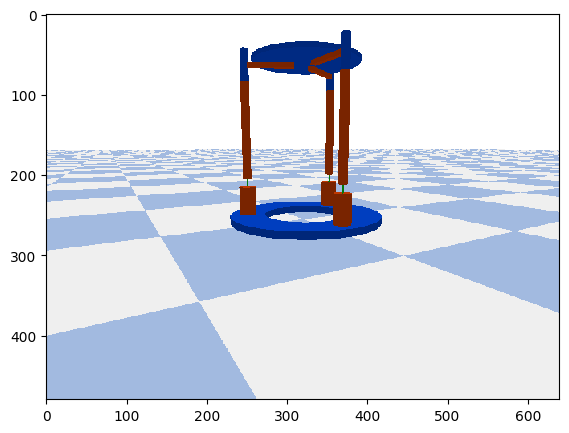

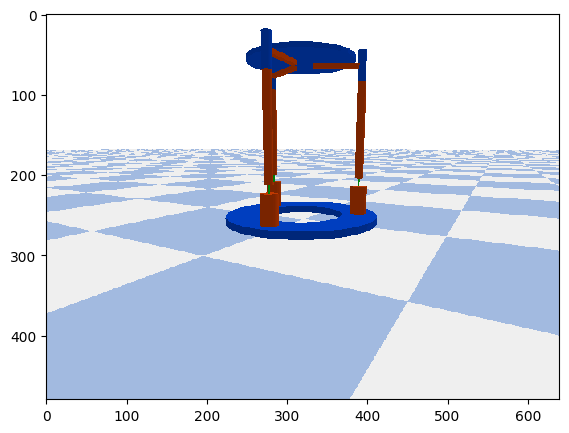

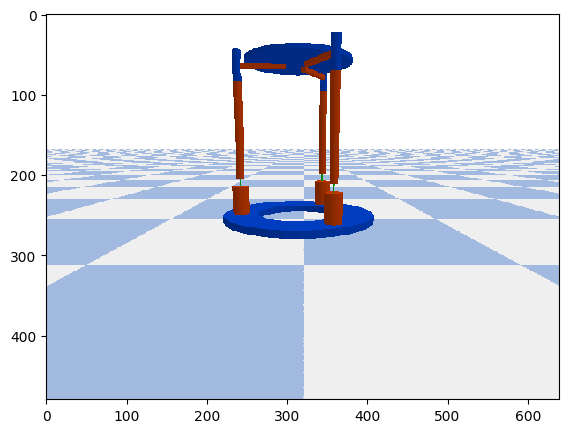

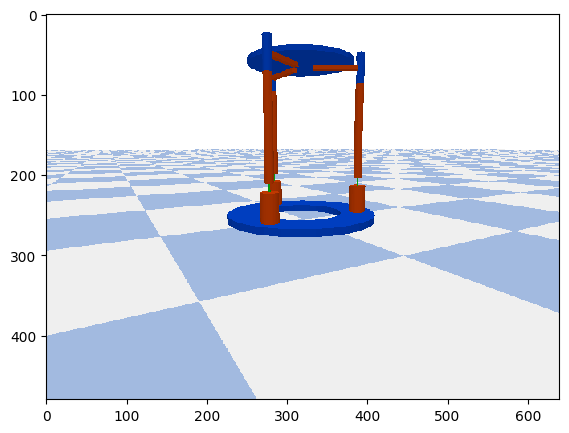

In [ ]:
# show changes in position
grid = widgets.Grid(2, 2)
yaw = 0
for r in range(2):
  for c in range(2):
    yaw += 60
    with grid.output_to(r, c):
      grid.clear_cell()
      pylab.figure(figsize=(10, 5))
      pitch = -10.0
      roll = 0
      upAxisIndex = 2
      camDistance = 2.5
      pixelWidth = 640
      pixelHeight = 480
      nearPlane = 0.01
      farPlane = 100
      fov = 60
      viewMatrix = p.computeViewMatrixFromYawPitchRoll(camTargetPos, camDistance, yaw, pitch,
                                                                  roll, upAxisIndex)
      aspect = pixelWidth / pixelHeight
      projectionMatrix = p.computeProjectionMatrixFOV(fov, aspect, nearPlane, farPlane)

      img_arr = p.getCameraImage(pixelWidth,pixelHeight,viewMatrix,projectionMatrix)
      w = img_arr[0]  #width of the image, in pixels
      h = img_arr[1]  #height of the image, in pixels
      rgb = img_arr[2]  #color data RGB
      dep = img_arr[3]  #depth data
      print("w=",w,"h=",h)
      np_img_arr = np.reshape(rgb, (h, w, 4))
      np_img_arr = np_img_arr * (1. / 255.)
      pylab.imshow(np_img_arr, interpolation='none', animated=True, label="pybullet")
